# Dask Implementation for doing the K-means clustering.

## Installing and importing the necessary libraries.

In [9]:
# Installing the libraries if not done already
# pip install "dask[complete]" 
# OR
# conda install "dask[complete]"

In [10]:
pip install dask_ml

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Importing the necessary libraries
import matplotlib.pyplot as plt 
import dask.dataframe as dd 
import dask.array as da 
import pandas as pd
from dask_ml.cluster import KMeans

# for finding the number of cores.
import multiprocessing

# for setting up the local cluster
from dask.distributed import Client, LocalCluster
import psutil

# For scaling the data
from sklearn.preprocessing import StandardScaler


In [12]:
#finding the number of cores
print(multiprocessing.cpu_count())

8


## Finding the system memory information

In [13]:
#Total RAM
print(f"Total RAM installed: {round(psutil.virtual_memory().total/1000000000, 2)} GB")
#Available RAM
print(f"Available RAM: {round(psutil.virtual_memory().available/1000000000, 2)} GB")
#Used RAM
print(f"Used RAM: {round(psutil.virtual_memory().used/1000000000, 2)} GB")
#RAM usage
print(f"RAM usage: {psutil.virtual_memory().percent} %")

Total RAM installed: 17.18 GB
Available RAM: 1.24 GB
Used RAM: 1.4 GB
RAM usage: 92.8 %


## Cluster Configuring

We will now configure the cluster

In [14]:
# Cluster Configuration
cluster = LocalCluster(n_workers=1, threads_per_worker=8, memory_limit = '2GB')
# explicitly connect to the cluster we just created
client = Client(cluster)
# Viewing the client and the cluster
client

Client Scheduler: tcp://127.0.0.1:57215 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 1.86 GiB


## Loading the dataset

In [15]:
# Load the dataset in to dask dataframe
ks2018 = dd.read_csv('/Users/umasid/My_Workspace/Dask Project/dataClean.csv', dtype={'usd_pledged': 'float64'}) 
# ks2018 = dd.read_csv('/Users/umasid/Uni/CS5811 - Distributed Data Analysis/Kickstarter project Data/dataClean.csv') 
ks2018.head()

,Unnamed: 0,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged,usd_goal,launch_gap
0,1,Poetry,Publishing,GBP,2015-10-09,2015-08-11,failed,0,GB,0.0,1533.95,59
1,2,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02,failed,15,US,2421.0,30000.00,60
2,4,Music,Music,USD,2012-04-16,2012-03-17,failed,1,US,1.0,5000.00,30
3,5,Film & Video,Film & Video,USD,2015-08-29,2015-07-04,canceled,14,US,1283.0,19500.00,56
4,7,Food,Food,USD,2014-12-21,2014-12-01,successful,16,US,1205.0,1000.00,20


## Creating a dataframe with numerical columns.

In [16]:
# Subsetting the main dataframe in to a new dataframe with only numerical columns.
ks2018_numeric = ks2018[['backers', 'usd_pledged', 'usd_goal','launch_gap']] 
ks2018_numeric.head()

,backers,usd_pledged,usd_goal,launch_gap
0,0,0.0,1533.95,59
1,15,2421.0,30000.00,60
2,1,1.0,5000.00,30
3,14,1283.0,19500.00,56
4,16,1205.0,1000.00,20


## Scaling the data

As the data in the numerical columns is in different ranges, we need to scale the data.

In [17]:
# Scaling the data.
scaler = StandardScaler()
ks2018_numeric_scaled = scaler.fit_transform(ks2018_numeric)

# statistics of scaled data
print(ks2018_numeric_scaled)

[[-0.75072897 -0.57714394 -0.71073197  1.93072952]
 [-0.28204694  0.20032083  3.18416549  2.00713748]
 [-0.7194835  -0.57682281 -0.23648601 -0.28510118]
 ...
 [-0.7194835  -0.57072127  1.13177459  0.9374261 ]
 [-0.56325616 -0.5129172   1.13177459 -0.20869323]
 [-0.219556   -0.40886987 -0.64696419 -0.43791709]]


## Clustering using k-means

In [18]:
# creating kmeans object with number of clusters as 2
km = KMeans(n_clusters = 2, init='k-means++')

In [19]:
# Fitting the dataframe
km.fit(ks2018_numeric_scaled)

KMeans(init='k-means++', n_clusters=2)

In [20]:
# inertia on the fitted data
km.inertia_

407371.6167378476

## Trying different number of clusters.

In [21]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for clusters in range(2,7):
    kmeans = KMeans(n_jobs = -1, n_clusters = clusters,init_max_iter = 100, init='k-means++')
    kmeans.fit(ks2018_numeric_scaled)
    SSE.append(kmeans.inertia_)



## Plotting the results

Text(0, 0.5, 'Inertia')

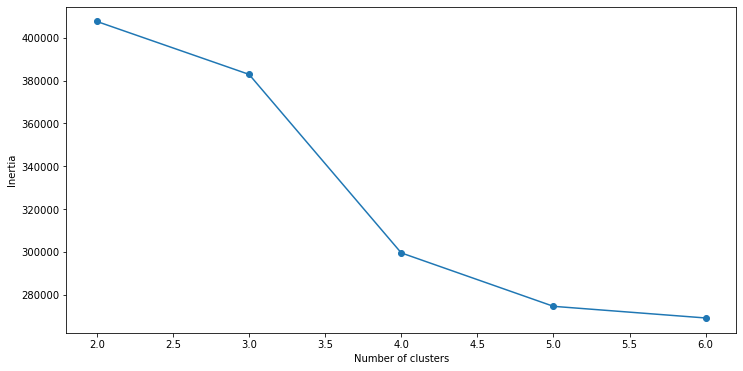

In [22]:
# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(2,7), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

## Clustering with the observed best number of clusters

In [23]:
# k means using 5 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++')
kmeans.fit(ks2018_numeric_scaled)
pred = kmeans.predict(ks2018_numeric_scaled)

## Printing the counts of each cluster

In [24]:
# find the valuecounts of each cluster.
frame = pd.DataFrame(ks2018_numeric_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()

1    147350
4     46654
3     40668
0     37296
2     15675
Name: cluster, dtype: int64

In [25]:
# Joining the dataframe with computed clusters.
ks2018_clusters = ks2018.compute()
ks2018_clusters['cluster'] = pred

In [26]:
# Looking at the cluster cloumn
ks2018_clusters['cluster']

0         3
1         0
2         1
3         0
4         1
         ..
287638    3
287639    1
287640    0
287641    0
287642    1
Name: cluster, Length: 287643, dtype: int32

In [27]:
ks2018_clusters

,Unnamed: 0,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged,usd_goal,launch_gap,cluster
0,1,Poetry,Publishing,GBP,2015-10-09,2015-08-11,failed,0,GB,0.0,1533.95,59,3
1,2,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02,failed,15,US,2421.0,30000.00,60,0
2,4,Music,Music,USD,2012-04-16,2012-03-17,failed,1,US,1.0,5000.00,30,1
3,5,Film & Video,Film & Video,USD,2015-08-29,2015-07-04,canceled,14,US,1283.0,19500.00,56,0
4,7,Food,Food,USD,2014-12-21,2014-12-01,successful,16,US,1205.0,1000.00,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
287638,378656,Poetry,Publishing,CAD,2014-09-20,2014-08-06,canceled,0,CA,0.0,4949.60,45,3
287639,378658,Narrative Film,Film & Video,USD,2011-07-19,2011-06-22,failed,5,US,155.0,1500.00,27,1
287640,378659,Narrative Film,Film & Video,USD,2010-08-16,2010-07-01,failed,1,US,20.0,15000.00,46,0
287641,378660,Technology,Technology,USD,2016-02-13,2016-01-13,failed,6,US,200.0,15000.00,31,0


## Exporting the final dataframe as csv

In [28]:
# Exporting the dataset. 
# ks2018_clusters.to_csv('F://Distributed Data Analysis CS5811/Assignment/data/ks2018_clustered.csv') 
ks2018_clusters.to_csv('ks2018_clustered.csv') 

## Closing the cluster and shutting down the client

In [29]:
cluster.close()
client.close()
client.shutdown


<bound method Client.shutdown of <Client: not connected>>